# Bayesian inference of the Light Curve PSD

In this tutorial, we will demonstrate how you can use MCMC with `pgmuvi` to get a posterior distribution of the PSD of a light curve. We will use the same type of data as in the [basic tutorial](pgmuvi_tutorial.ipynb).

## Why Bayesian inference?


## Why MCMC?




## This tutorial



### Some imports

In [1]:
try: #This won't work right now - instead clone the repository and `pip install -e .`
    import pgmuvi
except ImportError:
    %pip install git+https://github.com/ICSM/pgmuvi.git
    import pgmuvi

c:\Users\peter\anaconda3\envs\pgmuvi_dev\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#torch.multiprocessing.get_all_sharing_strategies()

### Creating the data

In [3]:
import torch
torch.multiprocessing.set_sharing_strategy('file_system')
import gpytorch
import numpy as np
""" Let's generate some synthetic data from a perturbed sine curve
    but on the same time sampling as the real data"""

P = np.random.uniform(30, 300)#137. #Days!
print("True period: ",P," days")
n_data = 40
jd_min = 2450000
n_periods = np.random.uniform(3,10)
jd_max = jd_min + P*(n_periods)
print("Simulating for ",n_periods," periods")

#train_mag =
#train_mag = train_mag + 0.1*torch.randn_like(train_mag)
#train_mag_err = 0.1*train_mag

period_guess = P*(np.random.uniform()+0.5)#147 #this number is in the same units as our original input.

#generate data from a simple case - superimpose two sine curves and add noise
timestamps_1d = torch.sort(torch.Tensor(np.random.uniform(jd_min, jd_max, size=n_data)))[0]#generate random x data here
fluxes_1d = torch.sin(timestamps_1d*(2*np.pi/P))#generate random y data here
fluxes_1d += 0.1*torch.randn_like(fluxes_1d)
flux_err_1d = 0.1*fluxes_1d.abs()
print("Generated data with ",n_data," points")
print("Period guess: ",period_guess," days")
print("Period guess: ",period_guess/P," periods")
print(timestamps_1d)
print(fluxes_1d)
print(flux_err_1d)

True period:  202.06875095309994  days
Simulating for  4.691146337866083  periods
Generated data with  40  points
Period guess:  126.5776478784249  days
Period guess:  0.6264088201733058  periods
tensor([2450053.7500, 2450063.7500, 2450077.2500, 2450086.0000, 2450092.0000,
        2450095.7500, 2450121.2500, 2450150.0000, 2450185.2500, 2450261.0000,
        2450263.5000, 2450275.2500, 2450297.5000, 2450380.7500, 2450393.7500,
        2450408.5000, 2450446.5000, 2450499.7500, 2450504.5000, 2450516.5000,
        2450518.5000, 2450541.7500, 2450571.0000, 2450576.5000, 2450617.7500,
        2450632.2500, 2450641.7500, 2450653.2500, 2450676.7500, 2450702.2500,
        2450702.7500, 2450743.7500, 2450788.0000, 2450800.2500, 2450808.2500,
        2450812.0000, 2450812.5000, 2450910.7500, 2450937.5000, 2450940.2500])
tensor([-0.8905, -0.6350, -0.1397,  0.1481,  0.2166,  0.3805,  0.9303,  0.6540,
         0.0011, -0.7813, -0.5887, -0.2197,  0.3481,  0.2984, -0.2618, -0.5272,
        -0.9249,  0

### Getting the Lightcurve object

In [4]:
from pgmuvi.lightcurve import Lightcurve

lightcurve_1d = Lightcurve(timestamps_1d, fluxes_1d, yerr = flux_err_1d, xtransform='minmax')

### Our Model

Now we can create our model. 
This is very similar to the previous tutorial, but with one small complication. 
When we didn't use MCMC, we wanted to learn additional diagonal noise to account for the intrinsic scatter of the data even if we had uncertainties on the data. 
However, when we use MCMC, we need to be careful about how we define our likelihood.
If we attempt to learn this additional noise, `gpytorch` will inject `NaN`s along the diagonal of the covariance matrix, which will cause the MCMC sampler to fail. 
However, if you don't have uncertainty information, you can still learn this additional noise.

In [5]:
# This won't work! Learning the additional noise results in NaNs in the covariance matrix during MCMC
# lightcurve_1d.set_model(model='1D', likelihood='learn', num_mixtures=1)

In [6]:
lightcurve_1d.set_model(model='1D', num_mixtures=1)

In [7]:
lightcurve_1d.print_parameters()
print(period_guess)
guess = {
         'sci_kernel.mixture_means': torch.Tensor([1/period_guess]),}
lightcurve_1d.set_hypers(guess)
lightcurve_1d.print_parameters()

mean_module.constant: 0.0
covar_module.mixture_weights: tensor([0.6589])
covar_module.mixture_means: tensor([[[0.1031]]])
covar_module.mixture_scales: tensor([[[0.0005]]])
126.5776478784249
mean_module.constant: 0.0
covar_module.mixture_weights: tensor([0.6589])
covar_module.mixture_means: tensor([[[0.0079]]])
covar_module.mixture_scales: tensor([[[0.0005]]])


In [8]:
print(lightcurve_1d._xdata_transformed)
print(lightcurve_1d._ydata_transformed)
print(lightcurve_1d._yerr_transformed)

tensor([0.0000, 0.0113, 0.0265, 0.0364, 0.0431, 0.0474, 0.0761, 0.1086, 0.1483,
        0.2338, 0.2366, 0.2499, 0.2750, 0.3689, 0.3835, 0.4002, 0.4430, 0.5031,
        0.5085, 0.5220, 0.5243, 0.5505, 0.5835, 0.5897, 0.6362, 0.6526, 0.6633,
        0.6763, 0.7028, 0.7315, 0.7321, 0.7783, 0.8283, 0.8421, 0.8511, 0.8553,
        0.8559, 0.9667, 0.9969, 1.0000])
tensor([-0.8905, -0.6350, -0.1397,  0.1481,  0.2166,  0.3805,  0.9303,  0.6540,
         0.0011, -0.7813, -0.5887, -0.2197,  0.3481,  0.2984, -0.2618, -0.5272,
        -0.9249,  0.3618,  0.4404,  0.6633,  0.8366,  1.0605,  0.6095,  0.4506,
        -0.7689, -1.1010, -1.1483, -0.9431, -0.2370,  0.5727,  0.4957,  1.0588,
         0.0777, -0.2049, -0.4922, -0.4729, -0.6669,  0.5285,  0.9364,  0.8785])
tensor([0.0890, 0.0635, 0.0140, 0.0148, 0.0217, 0.0381, 0.0930, 0.0654, 0.0001,
        0.0781, 0.0589, 0.0220, 0.0348, 0.0298, 0.0262, 0.0527, 0.0925, 0.0362,
        0.0440, 0.0663, 0.0837, 0.1060, 0.0610, 0.0451, 0.0769, 0.1101, 0.1148

### Doing MCMC

In [11]:
#try:
lightcurve_1d.mcmc(num_samples=1000, warmup_steps=500, num_chains=1)#num_samples=1000, burnin=100, thin=10, num_chains=4, num_steps=10, num_processes=4)
#except Exception as e:
    #print(e)
    #lightcurve_1d.mcmc(num_samples=100, num_chains=2)#num_samples=1000, burnin=100, thin=10, num_chains=4, num_steps=10, num_processes=4)

Sample: 100%|██████████| 1500/1500 [10:24,  2.40it/s, step size=4.57e-01, acc. prob=0.910]



                                              mean       std    median     15.8%     84.2%     n_eff     r_hat
 covar_module.mixture_means_prior[0,0,0]      4.38      0.11      4.38      4.29      4.47    599.86      1.00
covar_module.mixture_scales_prior[0,0,0]      0.15      0.08      0.13      0.05      0.19    648.46      1.00
   covar_module.mixture_weights_prior[0]      0.65      0.58      0.49      0.18      0.75    815.64      1.00
                  mean_module.mean_prior      0.03      0.02      0.03      0.00      0.05   1045.33      1.00
   sci_kernel.mixture_means_prior[0,0,0]      1.70      1.94      1.01      0.11      1.75    848.20      1.00
  sci_kernel.mixture_scales_prior[0,0,0]      1.58      1.84      1.02      0.11      1.64    935.99      1.00
     sci_kernel.mixture_weights_prior[0]      1.68      2.17      1.04      0.08      1.57    822.40      1.00

Number of divergences: 0


c:\Users\peter\anaconda3\envs\pgmuvi_dev\Lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


### Interpreting the results

First we want to make a quick summary of the results.
We can do this by plotting the marginal posterior distributions of each parameter, and by printing out the mean and standard deviation of each parameter. 
The mean and standard deviation are useful because they give us a sense of the "best fit" parameters, and the uncertainty on those parameters - or more formally, the credible interval of the parameters and the point estimate.

In [12]:
import arviz as az
az.summary(lightcurve_1d.inference_data)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"covar_module.mixture_means_prior[0, 0, 0]",4.382,0.107,4.185,4.610,0.004,0.003,626.0,577.0,NaN
"covar_module.mixture_scales_prior[0, 0, 0]",0.150,0.082,0.025,0.302,0.003,0.002,497.0,484.0,NaN
covar_module.mixture_weights_prior[0],0.652,0.578,0.092,1.467,0.020,0.014,937.0,868.0,NaN
mean_module.mean_prior,0.026,0.022,-0.016,0.069,0.001,0.001,988.0,645.0,NaN
"sci_kernel.mixture_means_prior[0, 0, 0]",1.702,1.944,0.039,5.217,0.066,0.049,995.0,721.0,NaN
"sci_kernel.mixture_scales_prior[0, 0, 0]",1.583,1.844,0.044,4.719,0.061,0.045,1267.0,664.0,NaN
sci_kernel.mixture_weights_prior[0],1.676,2.165,0.029,5.203,0.075,0.054,1054.0,581.0,NaN


We also want to take a look at how the MCMC sampler explored the parameter space. 
This is often referred to as the "trace" of the MCMC sampler.

array([[<Axes: title={'center': 'covar_module.mixture_means_prior'}>,
        <Axes: title={'center': 'covar_module.mixture_means_prior'}>],
       [<Axes: title={'center': 'covar_module.mixture_scales_prior'}>,
        <Axes: title={'center': 'covar_module.mixture_scales_prior'}>],
       [<Axes: title={'center': 'covar_module.mixture_weights_prior'}>,
        <Axes: title={'center': 'covar_module.mixture_weights_prior'}>],
       [<Axes: title={'center': 'mean_module.mean_prior'}>,
        <Axes: title={'center': 'mean_module.mean_prior'}>]], dtype=object)

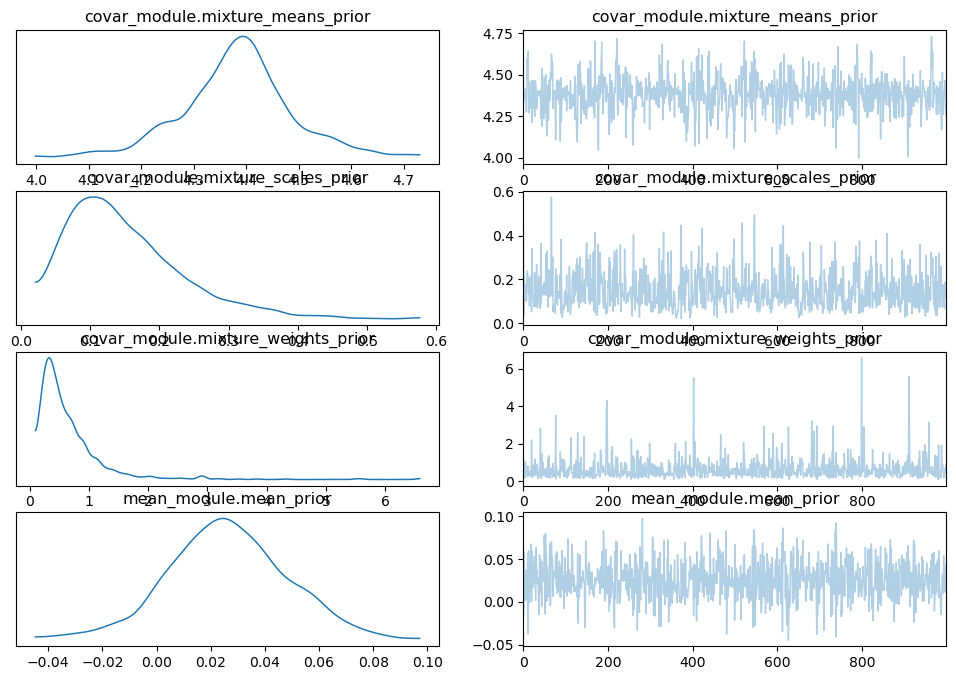

In [13]:
az.plot_trace(lightcurve_1d.inference_data, var_names=['mean_module', 'covar_module'], filter_vars="like")

Plotting the marginal posterior distributions is easy with `plot_pair`. `pgmuvi` often works best with `kind='scatter'`, but you can also try out `kind='kde'` or `kind='hexbin'` for prettier plots.

array([[<Axes: ylabel='covar_module.mixture_means_prior\n0, 0, 0'>,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='covar_module.mixture_scales_prior\n0, 0, 0'>,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='covar_module.mixture_weights_prior\n0'>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: xlabel='covar_module.mixture_means_prior\n0, 0, 0', ylabel='mean_module.mean_prior'>,
        <Axes: xlabel='covar_module.mixture_scales_prior\n0, 0, 0'>,
        <Axes: xlabel='covar_module.mixture_weights_prior\n0'>,
        <Axes: xlabel='mean_module.mean_prior'>]], dtype=object)

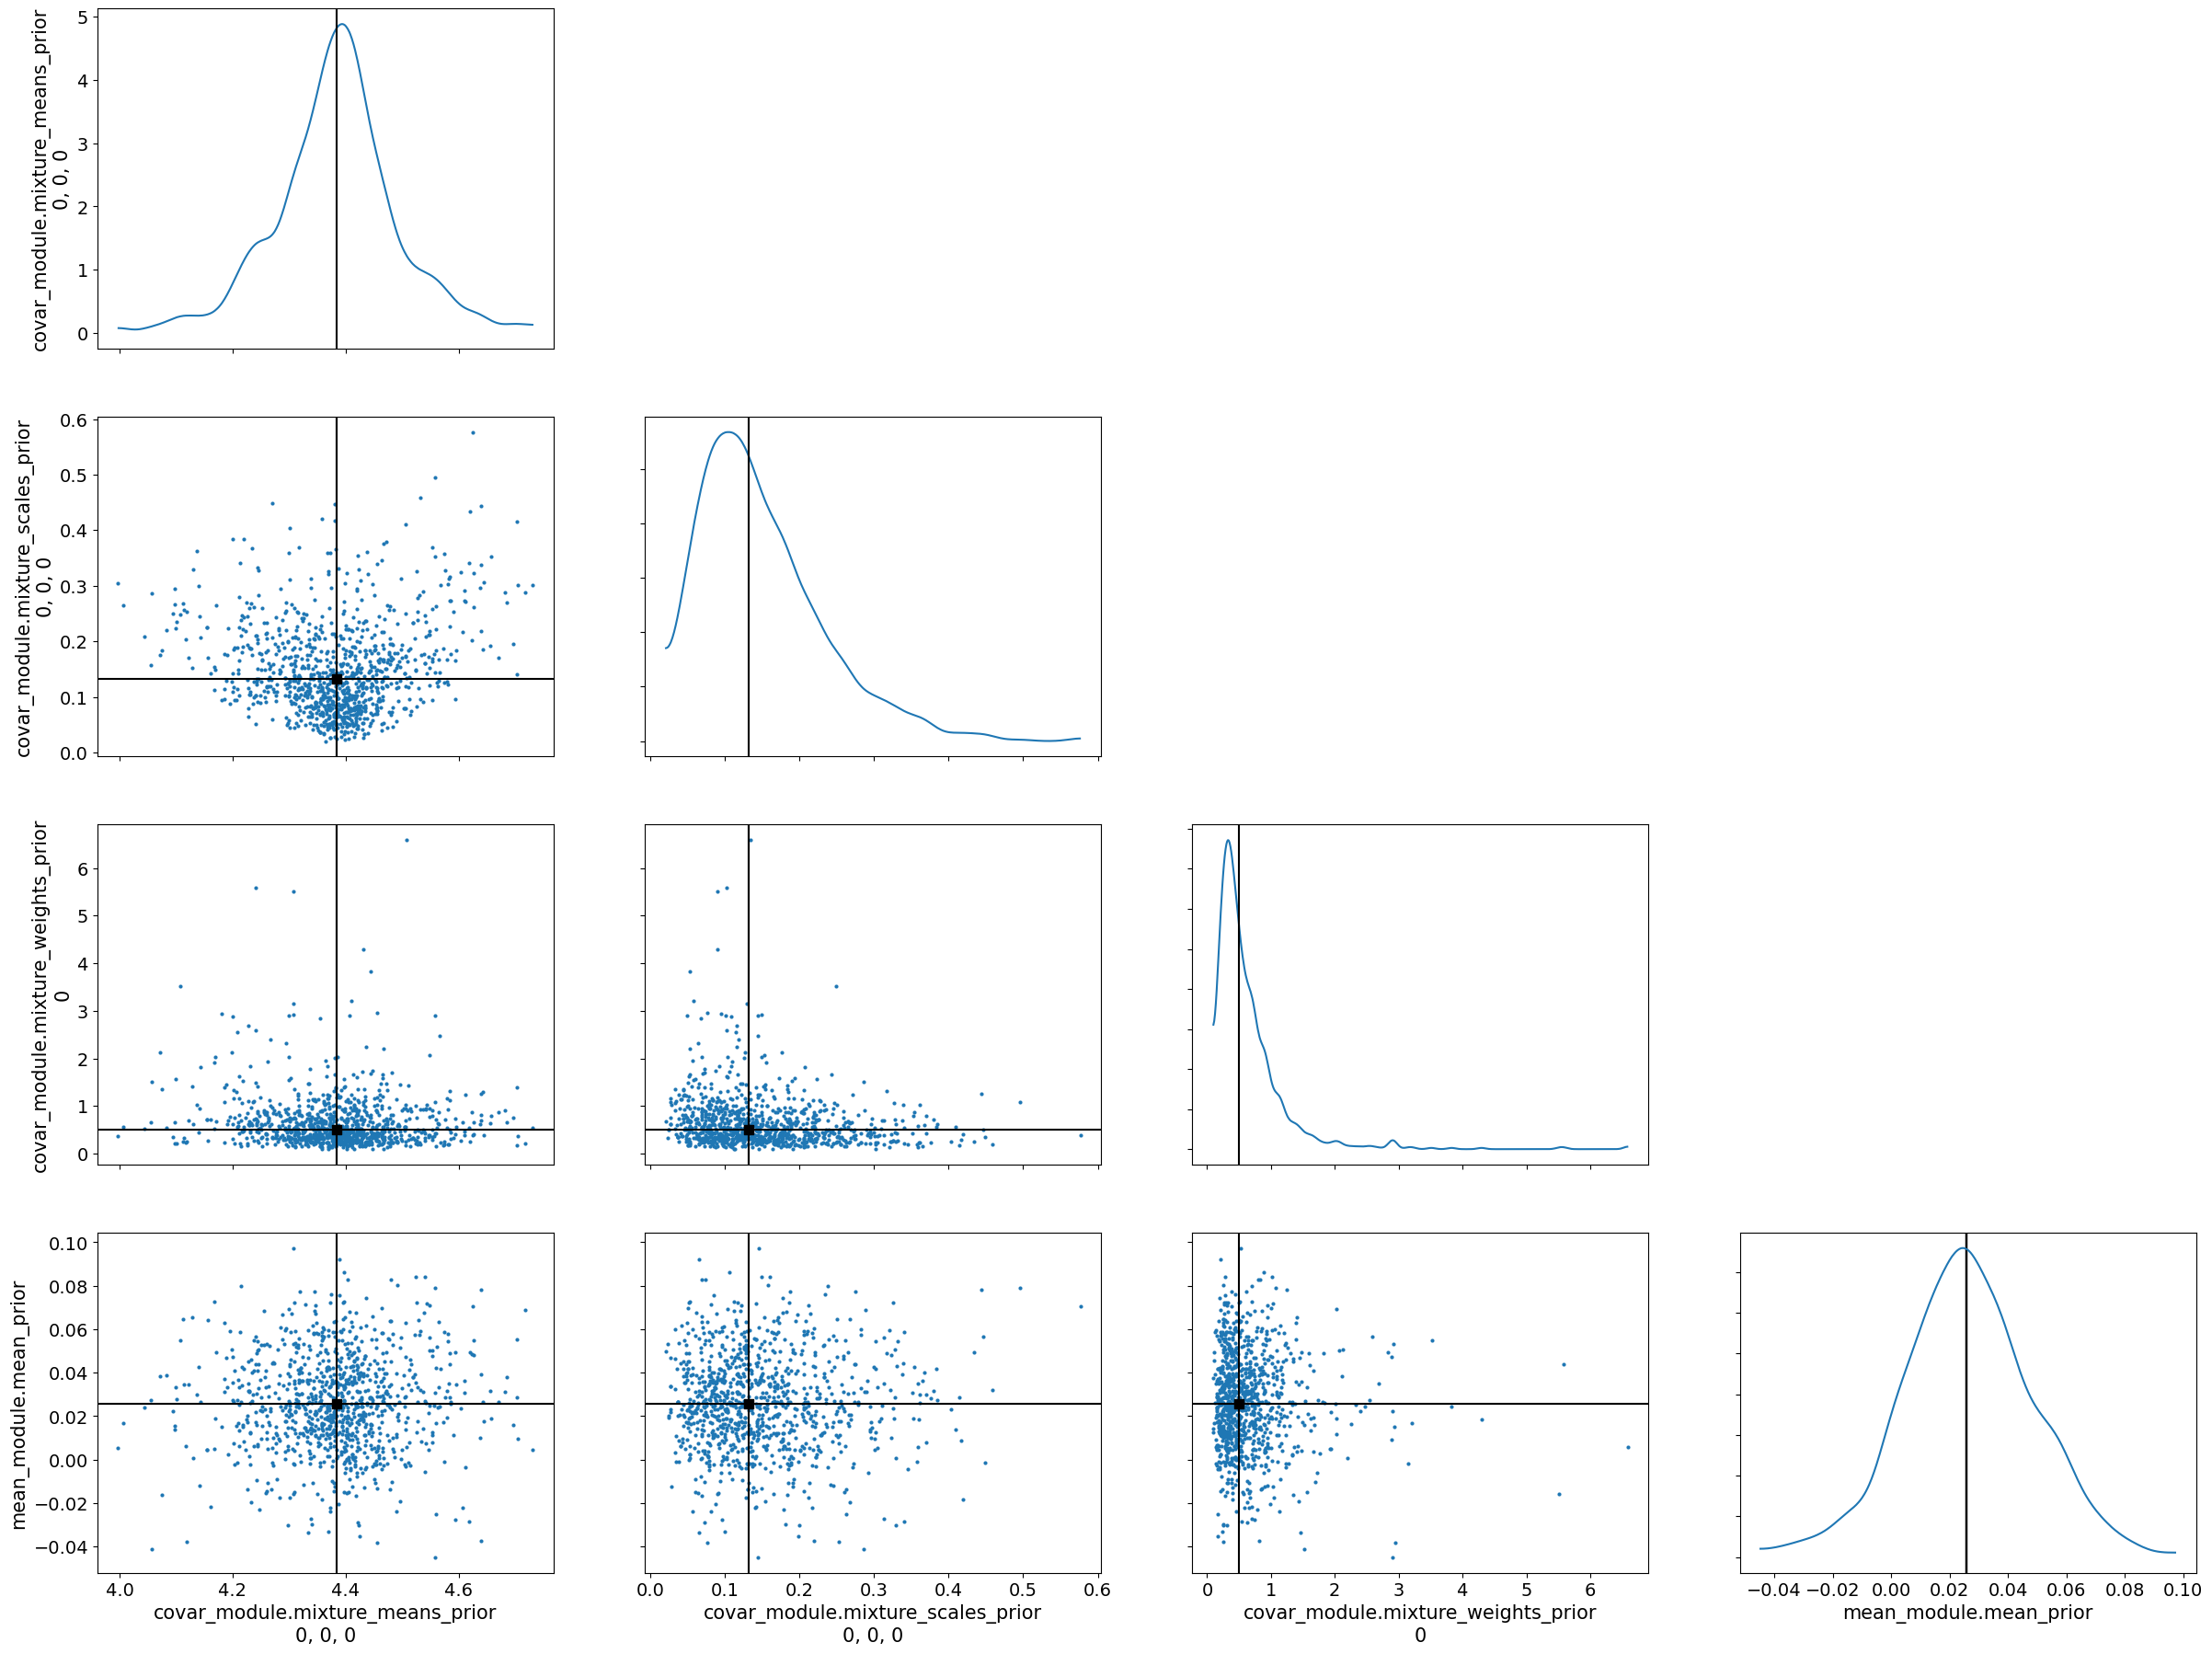

In [14]:
az.plot_pair(lightcurve_1d.inference_data, 
             kind='scatter', 
             var_names=['mean_module', 'covar_module'], filter_vars="like", 
             marginals=True,
             point_estimate='median'
             )

We also want to plot the light curve with samples from the posterior distribution of the model.

In [ ]:
# plot goes here

We might also want to look at the posterior distribution of the PSD.

In [ ]:
# plot goes here

Or we might want to examine the distribution of periods.

In [15]:
# output goes here